In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [72]:
velha = pd.read_csv('amostras_.csv',sep=';')
velha.describe

<bound method NDFrame.describe of      pos1  pos2  pos3  pos4  pos5  pos6  pos7  pos8  pos9       classe
0       0     0     0     0     0     0     0     0     0      Em_jogo
1       1     0     0     0     0     0     0     0     0      Em_jogo
2       1    -1     0     0     0     0     0     0     0      Em_jogo
3       1    -1     1     0     0     0     0     0     0      Em_jogo
4       1    -1     1    -1     0     0     0     0     0      Em_jogo
..    ...   ...   ...   ...   ...   ...   ...   ...   ...          ...
674    -1     1     1    -1     0     0    -1     0     1  Fim_de_jogo
675    -1     1     1     1    -1    -1     1    -1     1  Fim_de_jogo
676    -1     1     1     1    -1    -1    -1     1     1  Fim_de_jogo
677    -1     1     1     1     1    -1    -1    -1     1  Fim_de_jogo
678    -1    -1     1     1     1    -1    -1     1     1  Fim_de_jogo

[679 rows x 10 columns]>

In [73]:
X = velha.drop(columns=['classe'])
y = velha['classe'].values

In [74]:
treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=42,test_size=0.1, stratify=y)
print(treino_X.shape)
print(treino_y.shape)
tr_X, v_X, tr_y, v_y = tts(treino_X, treino_y, random_state=42,test_size=0.1, stratify=treino_y)


(611, 9)
(611,)


Validacao Cruzada com GridSearchCV

In [75]:
param_grid = {'n_neighbors': range(2, 20)}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=10,         # 10-fold cross-validation
    scoring='accuracy'
)
grid.fit(treino_X, treino_y)
print("Melhor k:", grid.best_params_)
print("Acurácia média de validação:", grid.best_score_)
melhor_k = grid.best_params_['n_neighbors']

Melhor k: {'n_neighbors': 14}
Acurácia média de validação: 0.6988894764674776


Validacao Explicita (10%)

In [76]:
melhor_k = None
melhor_acc = 0
for k in range(2, 20):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(teste_X, teste_y)
    acc = clf.score(v_X,v_y)
    if acc > melhor_acc:
        melhor_acc = acc
        melhor_k = k
print(f'Melhor acuracia: {melhor_acc}')
print("Melhor k encontrado:", melhor_k)

Melhor acuracia: 0.5645161290322581
Melhor k encontrado: 12


In [77]:
clf = neighbors.KNeighborsClassifier(n_neighbors=15)
clf.fit(treino_X, treino_y)
accs = clf.score(teste_X, teste_y)
print("Acuracia: ", accs)

Acuracia:  0.7205882352941176


In [78]:
k_values = []
accuracies = []
maior = 0
melhor_k = 2
predicoes= []
melhor_pred = []
for k in range(2, 20):
  clf = neighbors.KNeighborsClassifier(n_neighbors=k)
  clf.fit(treino_X.values, treino_y)
  print("k = ", k, "acuracia = ", clf.score(teste_X.values, teste_y))

  acertos = 0
  for i in range(0,len(teste_X)):
    predicao = clf.predict([teste_X.values[i]])
    predicoes.append(predicao)
    print(teste_X.values[i], "predicao: ", predicao)
    if predicao == teste_y[i]:
      acertos += 1
  acc = acertos / len(teste_X)
  print("Acertos: ", acertos)
  print("Erros: ", len(teste_X) - acertos)
  print("Acuracia: ", acc)
  k_values.append(k)
  accuracies.append(acc)
  if acc > maior:
    melhor_pred = predicoes
    maior = acc
    melhor_k = k
print("Melhor k: ", melhor_k)
print("Maior acuracia: ", maior)


k =  2 acuracia =  0.45588235294117646
[-1  1  0 -1  0  1 -1  1  0] predicao:  ['Fim_de_jogo']
[ 1 -1  1  0  0  1 -1  0  0] predicao:  ['Possibilidade_de_fim_de_jogo']
[ 0  1 -1  0  0  1  1  0 -1] predicao:  ['Em_jogo']
[ 0  1 -1 -1 -1  1  1 -1  1] predicao:  ['Em_jogo']
[-1  1 -1  0  1 -1  1 -1  1] predicao:  ['Em_jogo']
[ 0  1 -1  0  0  1  0 -1  0] predicao:  ['Em_jogo']
[ 0  1 -1  1 -1  0  1  0 -1] predicao:  ['Possibilidade_de_fim_de_jogo']
[-1  1 -1  1 -1 -1  1  0  1] predicao:  ['Em_jogo']
[-1  1 -1  1 -1  0  0  0  1] predicao:  ['Em_jogo']
[ 1 -1  1  1  1  0  0 -1 -1] predicao:  ['Fim_de_jogo']
[ 1 -1  1 -1 -1  0  1  0  0] predicao:  ['Em_jogo']
[-1  1  0 -1  1  1 -1 -1  1] predicao:  ['Fim_de_jogo']
[-1  1 -1  0  0  1  1  0  0] predicao:  ['Em_jogo']
[ 1 -1  1 -1  1 -1  0  0  0] predicao:  ['Em_jogo']
[ 0  1 -1  1 -1  1  1 -1  0] predicao:  ['Em_jogo']
[-1  1 -1  1 -1  1  0  1  0] predicao:  ['Fim_de_jogo']
[ 1 -1  1  0  1 -1  1  0 -1] predicao:  ['Possibilidade_de_fim_de_jogo'

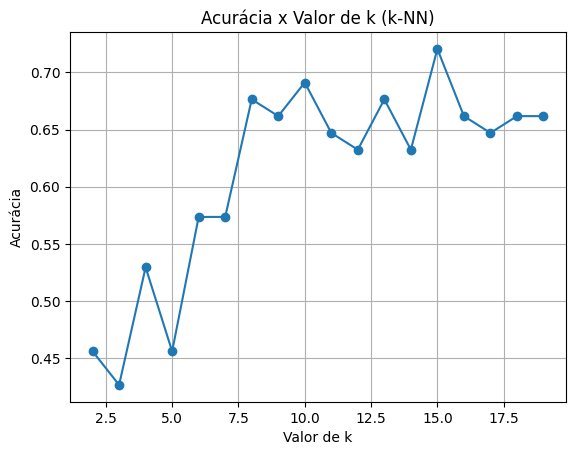

In [79]:
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("Valor de k")
plt.ylabel("Acurácia")
plt.title("Acurácia x Valor de k (k-NN)")
plt.grid(True)
plt.show()

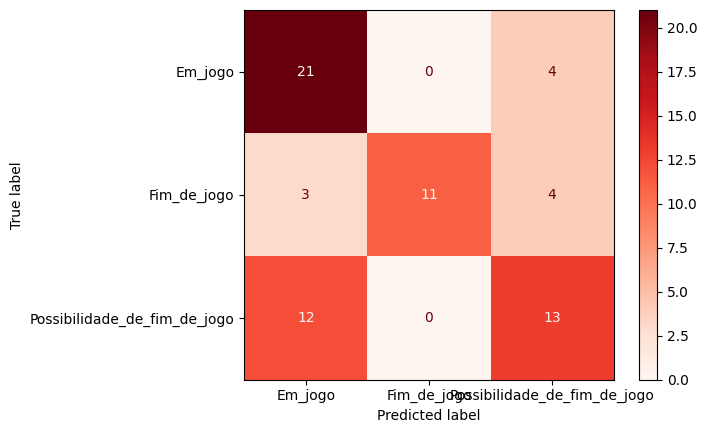

In [80]:
nomes_classes = velha.iloc[:, [9]].values
classes_unicas = np.unique(nomes_classes)
pred = clf.predict(teste_X.values)
cm = confusion_matrix(teste_y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_unicas)
disp.plot(cmap='Reds')